Import Libraries

In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Load datasets

In [2]:
# Preprocess the datasets
train = pd.read_parquet('train.parquet')
print(f"Train shape: {train.shape}")
test = pd.read_parquet('test.parquet')
print(f"Test shape: {test.shape}")

Train shape: (126700, 17)
Test shape: (31675, 17)


In [3]:
train.head()

,sender,receiver,date,subject,body,label,urls,combined_text,processed_text,tfidf_features,word2vec_features,transformer_features,sender_features,subject_features,date_features,body_features,body_features_2
0,eleanor foster <aceriwen@velnet.co.uk>,Nicolette Hudson <holden.salisbury@enron.com>,2001-08-22 07:27:04+00:00,Male muscle boosting system,"""I've been using your product for 4 months now...",1.0,1.0,"Male muscle boosting system ""I've been using y...",male muscle boosting system ive using product ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00971660204231739, 0.06431159377098083, 0.0...","[-0.06228220835328102, -0.00879708118736744, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 187.0, 4.540106951871658, 3.0, 0.0,..."
1,Lana Moore <Lana.Moore@nesanet.org>,'NESA Members' <eva.pollard@nesanet.org>,2001-10-23 15:04:52+00:00,NESA NYC Mixer - November 8,Please make plans to attend NESA's Membership ...,0.0,0.0,NESA NYC Mixer - November 8 Please make plans ...,nesa nyc mixer november please make plan atten...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04451704025268555, 0.0018677711486816406, ...","[-0.019170133396983147, -0.06289736181497574, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 64.0, 4.53125, 1.0, 0.0028169014084..."
2,Common Dreams <listreply@commondreams.org>,ktwarwic@flax9.uwaterloo.ca,2007-05-15 05:49:53+00:00,News & Views | 05.14.07,\n \n\nCommon Dreams - Breaking News & Views f...,0.0,1.0,News & Views | 05.14.07 \n \n\nCommon Dreams -...,news view common dream breaking news view prog...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005526355933398008, 0.04494216665625572, -...","[0.07190383970737457, -0.04377426207065582, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.0, 84.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 220.0, 10.027272727272727, 4.0, 0.0..."
3,"""Adam H. Kerman"" <ahk@chinet.chinet.com>",Pine Discussion Forum <pine-info@u.washington....,1998-01-08 07:10:16+00:00,Re: folder index - sender or recipient,">From: Jakob Kellner >Date: Thu, 8 Jan 1998 0...",0.0,0.0,Re: folder index - sender or recipient >From: ...,folder index sender recipient jakob kellner da...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0719418004155159, 0.00951385498046875, 0.02...","[0.032333265990018845, -0.03589319437742233, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 86.0, 4.686046511627907, 1.0, 0.0, ..."
4,Carl Helms <mxenitfrnpfkue@onlinetx.net>,opt4@flax9.uwaterloo.ca,2007-07-01 09:07:59+00:00,This is for you,\nThis is amazing stuff...\n\nAdd some inches ...,1.0,0.0,This is for you \nThis is amazing stuff...\n\n...,amazing stuffadd inch fast safe effective seen...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0525309257209301, -0.00717841275036335, 0....","[-0.08619339019060135, 0.05992841348052025, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.0, 11.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 30.0, 5.433333333333334, 1.0, 0.0, ..."


In [4]:
test.head()

,sender,receiver,date,subject,body,label,urls,combined_text,processed_text,tfidf_features,word2vec_features,transformer_features,sender_features,subject_features,date_features,body_features,body_features_2
0,Josiah Rivera <Gary.Washington@lambertpartners...,ktwarwic@flax9.uwaterloo.ca,2007-06-27 23:16:20+00:00,regalto,Men's Products' Discounts!!! 80% off SALE !!! ...,1.0,1.0,regalto Men's Products' Discounts!!! 80% off S...,regalto men product discount sale vaqra pill o...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01425081118941307, 0.03438971936702728, 0.0...","[-0.09238181263208389, 0.037367917597293854, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.0, 25.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 181.0, 4.983425414364641, 8.0, 0.01..."
1,Daily Top 10 <bhargav-buchhand@internetwebtool...,user7-ext4@gvc.ceas-challenge.cc,2008-07-31 12:34:32+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1.0,1.0,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,cnncom daily top daily top cnncom top video st...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0004533067112788558, 0.03454103693366051, -...","[-0.049507372081279755, -0.06389272958040237, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 293.0, 11.542662116040956, 100.0, 0..."
2,Alexis Kimball <skeweringbaton@saveourplanet.org>,mailn@flax9.uwaterloo.ca,2006-05-20 18:06:25+00:00,Don't waste your time. Cheap pills are here.,Dear customer.Wanna know how to save much on y...,1.0,0.0,Don't waste your time. Cheap pills are here. D...,dont waste time cheap pill dear customerwanna ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0284550990909338, 0.02321099303662777, -0.0...","[0.021192213520407677, 0.030631644651293755, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0.0, 3.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 95.0, 5.252631578947368, 0.0, 0.0, ..."
3,Carmela Rios <hfjdesmond@goldgeneration.com>,ktwarwic <ktwarwic@speedy.uwaterloo.ca>,1999-10-01 00:29:22+00:00,her barbour many champion,\n\n\nThis one will explode!\n\n\n\nTarget sym...,1.0,0.0,her barbour many champion \n\n\nThis one will ...,barbour many champion one explodetarget sym bv...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.036815643310546875, 0.01973724365234375, 0....","[-0.03742770478129387, -0.06625784933567047, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0.0, 15.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 33.0, 5.363636363636363, 4.0, 0.058..."
4,Daily Top 10 <sluc1977@34direct.net>,email265@gvc.ceas-challenge.cc,2008-08-06 20:56:29+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1.0,1.0,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,cnncom daily top daily top cnncom top video st...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0004533067112788558, 0.03454103693366051, -...","[-0.049507372081279755, -0.06389272958040237, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 293.0, 11.46075085324232, 100.0, 0...."


Label Distribution in Training Set:
Label 0.0: 67213
Label 1.0: 59487


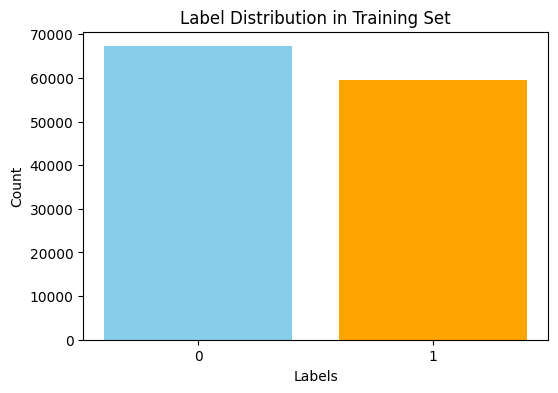

In [5]:
# Combine pre-extracted features into the feature set
def combine_features(df):
    sender_features = np.array(df['sender_features'].tolist())
    subject_features = np.array(df['subject_features'].tolist())
    date_features = np.array(df['date_features'].tolist())
    body_features = np.array(df['body_features'].tolist())
    tfidf_features = np.array(df['tfidf_features'].tolist())
    word2vec_features = np.array(df['word2vec_features'].tolist())
    
    # Concatenate all feature sets along the columns (axis=1)
    return np.concatenate([sender_features, subject_features, date_features, body_features, tfidf_features, word2vec_features], axis=1)

# Combine the pre-extracted features for both train and test
X_train_combined = combine_features(train)
X_test_combined = combine_features(test)

# Prepare the label data
y_train = train['label'].values
y_test = test['label'].values

# Count unique values and their occurrences
unique, counts = np.unique(y_train, return_counts=True)

# Print label distribution
print("Label Distribution in Training Set:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=['skyblue', 'orange'])
plt.title("Label Distribution in Training Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(unique)  # Ensure the labels match the unique values
plt.show()




Train LinearSVC model

In [6]:
from sklearn.svm import LinearSVC

# Train a LinearSVC model
linear_svc_model = LinearSVC(random_state=42, max_iter=1000, dual=False)  
linear_svc_model.fit(X_train_combined, y_train)

# Make predictions
y_pred_linear = linear_svc_model.predict(X_test_combined)

In [7]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_linear)

# Extract TP, FP, FN, TN
TP = cm[1, 1]  # True Positives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives
TN = cm[0, 0]  # True Negatives

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Print the overall metrics
print(f"Overall Metrics:\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Overall Metrics:

Accuracy: 0.9774
Precision: 0.9751
Recall: 0.9764
F1-Score: 0.9757


Hyperparameter Tuning using GridSearchCV

We will use `GridSearchCV` to tune the hyperparameters of the LinearSVC model to improve performance. The key parameters to optimize are:
- **C**: Regularization strength
- **max_iter**: Maximum iterations for solver
- **loss**: Loss function ( `'squared_hinge'`)
- **tol**: Tolerance for stopping criteria
- **penalty**: Regularization type
- **class_weight**: Weight for class

Cross-validation with 5 folds and F1-score as the metric will be used to find the best parameter combination.

In [8]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1e-4, 1e-3, 1e-2, 0.1, 1, 10], # Regularization parameter
    'max_iter': [1000, 2000],
    'loss': ['squared_hinge'],  # Only keep supported loss
    'tol': [1e-4, 1e-3, 1e-2], # Tolerance for stopping criteria
    'penalty': ['l2'],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0)
grid_search.fit(X_train_combined, y_train)
print("Best Parameters:", grid_search.best_params_)

# Retrain with the best parameters automatically
best_linear_svc_model = LinearSVC(random_state=42, **grid_search.best_params_)
best_linear_svc_model.fit(X_train_combined, y_train)

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.0001}


LinearSVC(C=1, class_weight='balanced', random_state=42)

In [9]:
y_pred = best_linear_svc_model.predict(X_test_combined)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, FP, FN, TN
TP = cm[1, 1]  # True Positives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives
TN = cm[0, 0]  # True Negatives

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Print the overall metrics
print(f"Overall Metrics:\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

Overall Metrics:

Accuracy: 0.9773
Precision: 0.9737
Recall: 0.9777
F1-Score: 0.9757


The model's performance remains strong after grid search, with a slight improvement in recall, indicating better detection of positive cases, while precision, accuracy, and F1-score remain stable, showcasing the model’s effectiveness.

Plot Confusion Matrix

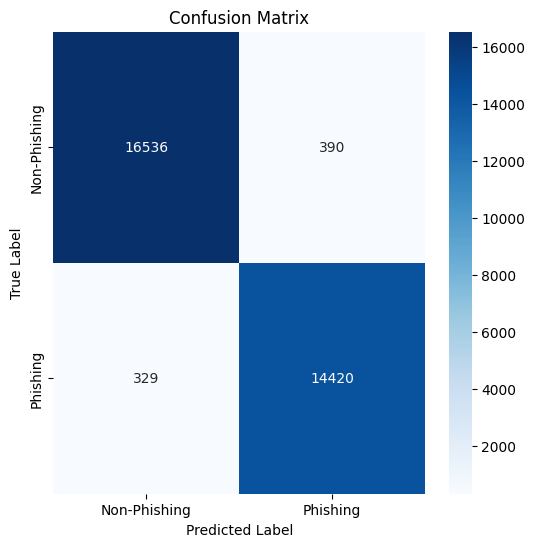

In [19]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
